# Estimating spatial metabolomics from spatial transcriptomics using MEBOCOST

## Brief introduction

In this tutorial, we demonstrate how to estimate spatial metabolomics maps from spatial transcriptomics datasets using MEBOCOST [[Zheng et.al, 2025](https://academic.oup.com/nar/article/53/12/gkaf569/8174779)]. These inferred metabolite fluxes can then be integrated into MetaChat to infer metabolic cell communication (MCC).

MEBOCOST infers whether a metabolite is active in a cell by calculating the average expression of its producing‐enzyme genes minus the average expression of its consuming-enzyme genes.

MEBOCOST can infer the activity of 591 metabolites with very fast computation. However, since the estimation is based on a simple summation of producing and consuming enzyme expression, the biological plausibility of the inferred metabolite levels should be interpreted with caution.

## Installation

You can follow the guideline of installation from [tutorials of MEBOCOST](https://github.com/kaifuchenlab/MEBOCOST?tab=readme-ov-file).

Create an independent environment
```bash
mamba create -n mebocost python=3.12
mamba activate mebocost
```

Download MEBOCOST
```bash
git clone https://github.com/kaifuchenlab/MEBOCOST.git
cd MEBOCOST
```

Install requirements:
```bash
pip install -r requirements.txt
python -m pip install .
```

## Usage

In [28]:
# Importing packages
import os
import scanpy as sc
import pandas as pd
import anndata as ad
from mebocost import mebocost

In [19]:
# Setting your work directory
os.chdir("/home/project/metachat/other_packages/MEBOCOST/")

Here, we use an example dataset from [https://support.10xgenomics.com/spatial-gene-expression/datasets](https://support.10xgenomics.com/spatial-gene-expression/datasets), which also can be download from [zenodo](https://zenodo.org/records/12629999).

In [20]:
adata_RNA = sc.read("/home/project/metachat_packages/datasets/visium_10x_mouse_brain/adata_RNA.h5ad")

In [21]:
adata_RNA

AnnData object with n_obs × n_vars = 2702 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Create a mebocost object

In [22]:
mebo_obj = mebocost.create_obj(
    adata = adata_RNA,
    ## "Celltype" must be a column name of adata.obs table, otherwise, change it according to your data.
    group_col = 'in_tissue', 
    condition_col = None,
    met_est = 'mebocost',
    # make sure mebocost.conf file in the same folder of this notebook, otherwise, provide a absolute path.
    config_path = '/home/project/metachat/other_packages/MEBOCOST/src/mebocost.conf', 
    exp_mat=None,
    cell_ann=None,
    ## make sure you set the right species
    species='mouse',
    met_pred=None,
    met_enzyme=None,
    met_sensor=None,
    met_ann=None,
    scFEA_ann=None,
    compass_met_ann=None,
    compass_rxn_ann=None,
    cutoff_exp='auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
    cutoff_met='auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
    cutoff_prop=0.15, ## at lease 10% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
    sensor_type='All',
    thread=8
)

[October 19, 2025 16:56:40]: We get expression data with 32285 genes and 2702 cells.
[October 19, 2025 16:56:40]: Data Preparation Done in 0.0005 seconds


In [23]:
mebo_obj._load_config_()
mebo_obj.estimator()

[October 19, 2025 16:56:41]: Load config and read data based on given species [mouse].
[October 19, 2025 16:56:41]: Estimtate metabolite enzyme expression using mebocost


Get the estimated metabolite abundance.

In [27]:
met_mat = pd.DataFrame(mebo_obj.met_mat.toarray(),
                      index = mebo_obj.met_mat_indexer,
                      columns = mebo_obj.met_mat_columns)

Save to your path.

In [30]:
met_mat.to_csv("/home/project/metachat_packages/datasets/visium_10x_mouse_brain/mebocost/estimated_metabolite.csv", index=True, header=True)

Change back to `MetaChat` environment

In [1]:
# Importing packages
import os
import scanpy as sc
import pandas as pd
import anndata as ad

In [2]:
# Setting your work directory
os.chdir("/home/project/metachat_packages/")

In [3]:
import sys
sys.path.append("/home/project/metachat_packages/MetaChat-main")
import metachat_new as mc

In [4]:
adata_RNA = sc.read("datasets/visium_10x_mouse_brain/adata_RNA.h5ad")

In [5]:
adata_RNA

AnnData object with n_obs × n_vars = 2702 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
adata_RNA.var_names_make_unique()
adata_RNA.raw = adata_RNA
sc.pp.normalize_total(adata_RNA, inplace=True, target_sum=1e5)
sc.pp.log1p(adata_RNA)

In [7]:
adata_META = mc.pp.generate_adata_met_mebocost('datasets/visium_10x_mouse_brain/mebocost/estimated_metabolite.csv')

In [8]:
adata_META

AnnData object with n_obs × n_vars = 2702 × 591

In [9]:
adata_combined = ad.concat([adata_RNA, adata_META], axis=1, join="outer")
adata_combined.obs = adata_RNA.obs.copy()
adata_combined.uns = adata_RNA.uns.copy()
adata_combined.obsm = adata_RNA.obsm.copy()

At this stage, we can visualize glutamate, glutamine, and GABA as examples, using their corresponding HMDB IDs.

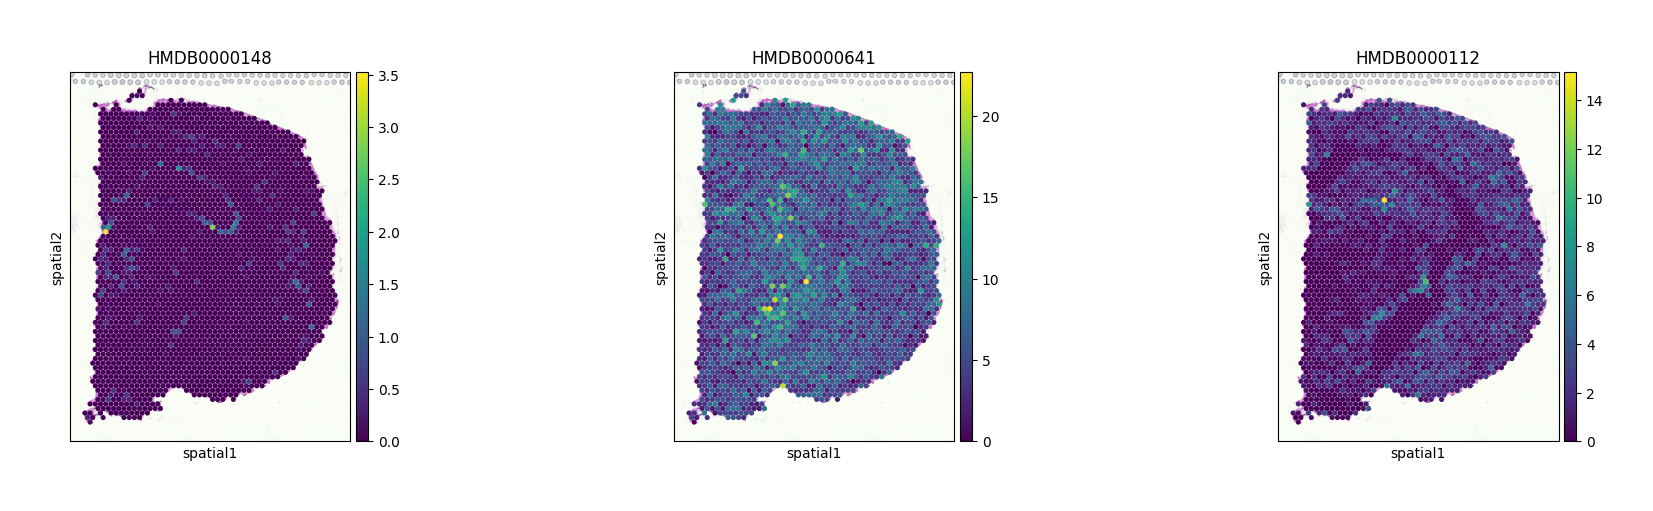

In [10]:
sc.pl.spatial(adata_combined, color=["HMDB0000148", "HMDB0000641", "HMDB0000112"], size=1.5)